# MHEALTH
- MHEALTH (Mobile Health) 데이터셋은 2013년 스페인 그라나다 대학에서 공개한, 신체 여러 부위에 부착된 센서를 이용한 인간 활동 인식 데이터셋
    - 목적: 가슴, 오른쪽 발목, 왼쪽 팔 3곳의 센서와 2채널 ECG(심전도)를 사용해, 10명의 피험자가     수행하는 12가지 활동을 기록.
    - 피험자: 10명 (8명의 남성, 2명의 여성, 24~32세).
    - 센서: Shimmer2R 웨어러블 센서 3개 (가슴, 발목, 팔), 2-lead ECG 1개 (가슴 센서에 통합).

---
실험 설정 및 센서 구성
1. 센서 위치 (총 3개 위치) 피험자는 3곳에 센서를 부착했습니다. 이것이 acc_chest_, acc_ankle_, acc_arm_ 등 컬럼명의 유래
    - 가슴 (Chest): 3축 가속도계 1개, 2-lead ECG 1개.
    - 오른쪽 발목 (Ankle): IMU 1개 (3축 가속도계, 3축 자이로스코프, 3축 지자기센서).
    - 왼쪽 팔 (Arm): IMU 1개 (3축 가속도계, 3축 자이로스코프, 3축 지자기센서).

2. 샘플링 속도 (Sampling Rate)
    - 모든 센서: 50Hz (1초에 50번 측정)
    - PAMAP2(100Hz/9Hz)와 달리 모든 센서의 샘플링 속도가 50Hz로 동일하여, 데이터가 이미 한 줄로 완벽하게 정렬. (결측치 없음)
---
컬럼 상세 (총 24개 컬럼)
- 데이터는 10개의 .log 파일에 피험자별로 나뉘어 저장
1. 가슴(Chest) 센서 (총 5개)
    - acc_chest_x/y/z: (float, 3개) 가속도계.
    - ecg_1 / ecg_2: (float, 2개) 심전도 신호.

2. 발목(Ankle) IMU (총 9개)
    - acc_ankle_x/y/z: (float, 3개) 가속도계.
    - gyro_ankle_x/y/z: (float, 3개) 자이로스코프 (각속도).
    - mag_ankle_x/y/z: (float, 3개) 지자기센서 (방향).

3. 팔(Arm) IMU (총 9개)
    - acc_arm_x/y/z: (float, 3개) 가속도계.
    - gyro_arm_x/y/z: (float, 3개) 자이로스코프 (각속도).
    - mag_arm_x/y/z: (float, 3개) 지자기센서 (방향).

4. 타겟 변수 (1개)
    - activity_id: (int) 활동 레이블. 아래 상세 설명 참조.
---
타겟 변수: activity_id (총 13개)
```Bash
0. Other (Transient),전환 활동. (예: 걷기 시작, 멈춤). 노이즈로 간주하며 모델 학습 시 반드시 제거.
1. Standing still
2. Sitting and relaxing
3. Lying down
4. Walking
5. Climbing stairs
6. Waist bends forward
7. Frontal elevation of arms
8. Knees bending (crouching)
9. Cycling
10. Jogging
11. Running
12. Jump front & back
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from scipy.fft import fft
from scipy.fft import fftfreq
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [6]:
BASE_PATH = r"C://Users/park9/HAR-EDA/MHEALTHDATASET" 

# 컬럼명 (Readme.txt 기준, 총 24개)
COLUMN_NAMES = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',  # 0-2 (Chest Acc)
    'ecg_1', 'ecg_2',                           # 3-4 (ECG)
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',  # 5-7 (Ankle Acc)
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z', # 8-10 (Ankle Gyro)
    'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',   # 11-13 (Ankle Mag)
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',       # 14-16 (Arm Acc)
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',    # 17-19 (Arm Gyro)
    'mag_arm_x', 'mag_arm_y', 'mag_arm_z',      # 20-22 (Arm Mag)
    'activity_id'                               # 23 (Label)
]

df_list = []

try:
    print(f"Loading .log files from: '{BASE_PATH}'")
    
    # --- 2. 10개 로그 파일 순회 및 로드 ---
    for i in range(1, 11): # subject 1 to 10
        file_name = f'mHealth_subject{i}.log'
        file_path = os.path.join(BASE_PATH, file_name)
        
        if not os.path.exists(file_path):
            print(f"Warning: {file_name} not found. Skipping.")
            continue
            
        print(f"Loading {file_name}...")
        
        # MHEALTH 데이터는 공백(space)으로 구분됨
        # pd.read_csv가 np.loadtxt보다 빠름
        df_subject = pd.read_csv(
            file_path,
            sep=r'\s+', # 공백 구분
            header=None,
            names=COLUMN_NAMES
        )
        df_subject['subject_id'] = i # 피험자 ID 추가
        df_list.append(df_subject)

    if not df_list:
        raise FileNotFoundError(f"No log files found in '{BASE_PATH}'.")

    # --- 3. 모든 피험자 데이터 병합 ---
    df_raw = pd.concat(df_list, axis=0).reset_index(drop=True)
    
    # --- 4. 레이블 매핑 (0은 'Other'이므로 제거) ---
    ACTIVITY_MAP = {
        0: 'Other (Transient)', # (제외 대상)
        1: 'Standing',
        2: 'Sitting',
        3: 'Lying',
        4: 'Walking',
        5: 'Climbing stairs',
        6: 'Waist bends',
        7: 'Knees bending',
        8: 'Cycling',
        9: 'Jogging',
        10: 'Running',
        11: 'Jumping',
        12: 'Push-ups'
    }
    df_raw['activity_name'] = df_raw['activity_id'].map(ACTIVITY_MAP)
    
    # 'Other' (activity_id == 0) 데이터는 제외
    initial_rows = len(df_raw)
    df_raw = df_raw[df_raw['activity_id'] != 0].copy()
    print(f"\nRemoved {initial_rows - len(df_raw)} rows (ID 0 'Other')")
    
    # --- 5. 로드 결과 확인 ---
    print(f"\nLoad successful! (Total {len(df_raw)} samples)")
    print("\nData Info (info):")
    df_raw.info()
    
    print("\nLoaded Data (head):")
    display(df_raw.tail())
    
    print("\nUnique Activities and Subjects:")
    print(f"Activities: {df_raw['activity_name'].nunique()} types")
    print(f"Subjects: {df_raw['subject_id'].nunique()} subjects")

except FileNotFoundError:
    print(f"Error: File not found! 😱")
    print(f"Please check the path: {BASE_PATH}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading .log files from: 'C://Users/park9/HAR-EDA/MHEALTHDATASET'
Loading mHealth_subject1.log...
Loading mHealth_subject2.log...
Loading mHealth_subject3.log...
Loading mHealth_subject4.log...
Loading mHealth_subject5.log...
Loading mHealth_subject6.log...
Loading mHealth_subject7.log...
Loading mHealth_subject8.log...
Loading mHealth_subject9.log...
Loading mHealth_subject10.log...

Removed 872550 rows (ID 0 'Other')

Load successful! (Total 343195 samples)

Data Info (info):
<class 'pandas.core.frame.DataFrame'>
Index: 343195 entries, 6656 to 1213645
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   acc_chest_x    343195 non-null  float64
 1   acc_chest_y    343195 non-null  float64
 2   acc_chest_z    343195 non-null  float64
 3   ecg_1          343195 non-null  float64
 4   ecg_2          343195 non-null  float64
 5   acc_ankle_x    343195 non-null  float64
 6   acc_ankle_y    343195 non-null  float64
 7

,acc_chest_x,acc_chest_y,acc_chest_z,ecg_1,ecg_2,acc_ankle_x,acc_ankle_y,acc_ankle_z,gyro_ankle_x,gyro_ankle_y,...,acc_arm_z,gyro_arm_x,gyro_arm_y,gyro_arm_z,mag_arm_x,mag_arm_y,mag_arm_z,activity_id,subject_id,activity_name
1213641,-21.947,3.9236,-6.2258,0.133960,0.163270,-2.4873,-19.233,3.4614,0.61967,-0.33771,...,2.48090,-0.43725,-1.0185,0.079741,-0.2130,14.6060,8.5139,12,10,Push-ups
1213642,-21.914,2.7521,-12.2790,-0.087912,-0.083726,-21.5910,-19.437,-6.0419,0.61967,-0.33771,...,3.65600,-0.43725,-1.0185,0.079741,8.6185,36.0000,-21.1260,12,10,Push-ups
1213643,-21.814,-2.7274,-12.7090,-0.309790,-0.200940,7.5433,-19.245,-2.6680,0.61967,-0.33771,...,4.46060,-0.43725,-1.0185,0.079741,16.9530,7.6535,-34.3950,12,10,Push-ups
1213644,-21.790,-3.9229,-7.2794,-0.443750,-0.259550,3.0142,-19.334,-7.7074,0.71058,-0.27017,...,1.15880,-0.42549,-1.0370,0.084052,25.3750,-29.7960,4.0546,12,10,Push-ups
1213645,-14.451,-1.6723,-4.7926,1.908900,1.385700,-2.3698,-19.300,-4.2387,0.71058,-0.27017,...,-0.13123,-0.42549,-1.0370,0.084052,12.0000,33.0610,33.1220,12,10,Push-ups



Unique Activities and Subjects:
Activities: 12 types
Subjects: 10 subjects


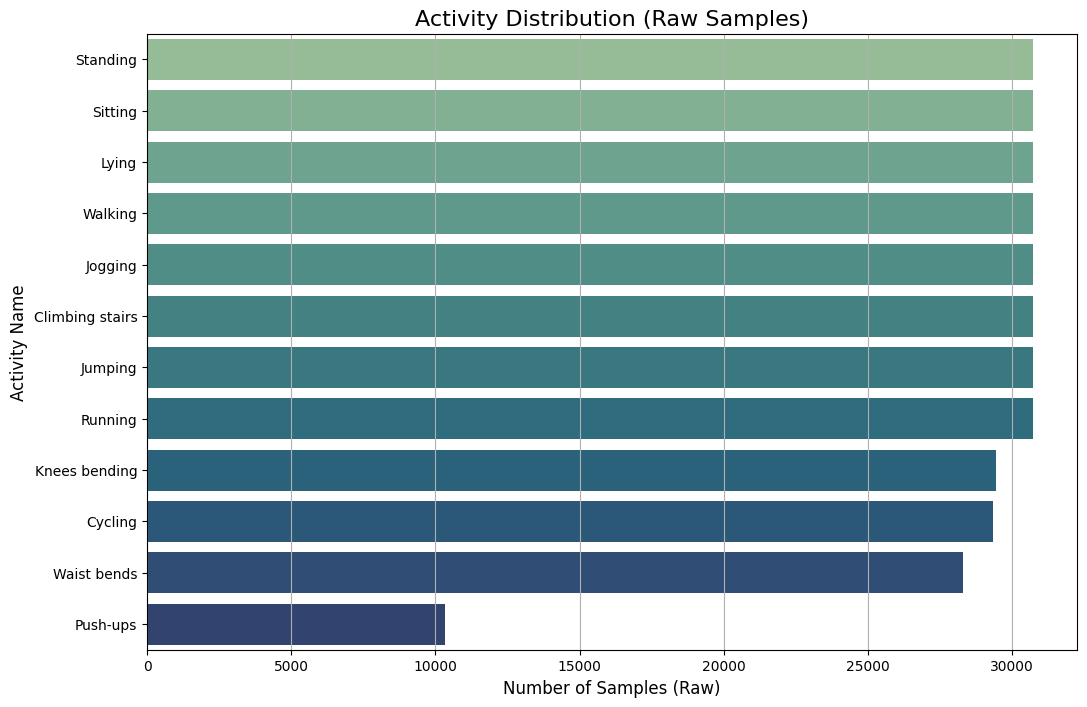

In [20]:
# MHEALTH has 12 activities, so a horizontal plot is better
plt.figure(figsize=(12, 8))
sns.countplot(
    y='activity_name', 
    data=df_raw, 
    order=df_raw['activity_name'].value_counts().index,
    palette="crest"
)
plt.title('Activity Distribution (Raw Samples)', fontsize=16,)
plt.xlabel('Number of Samples (Raw)', fontsize=12)
plt.ylabel('Activity Name', fontsize=12)
plt.grid(axis='x')
plt.show()

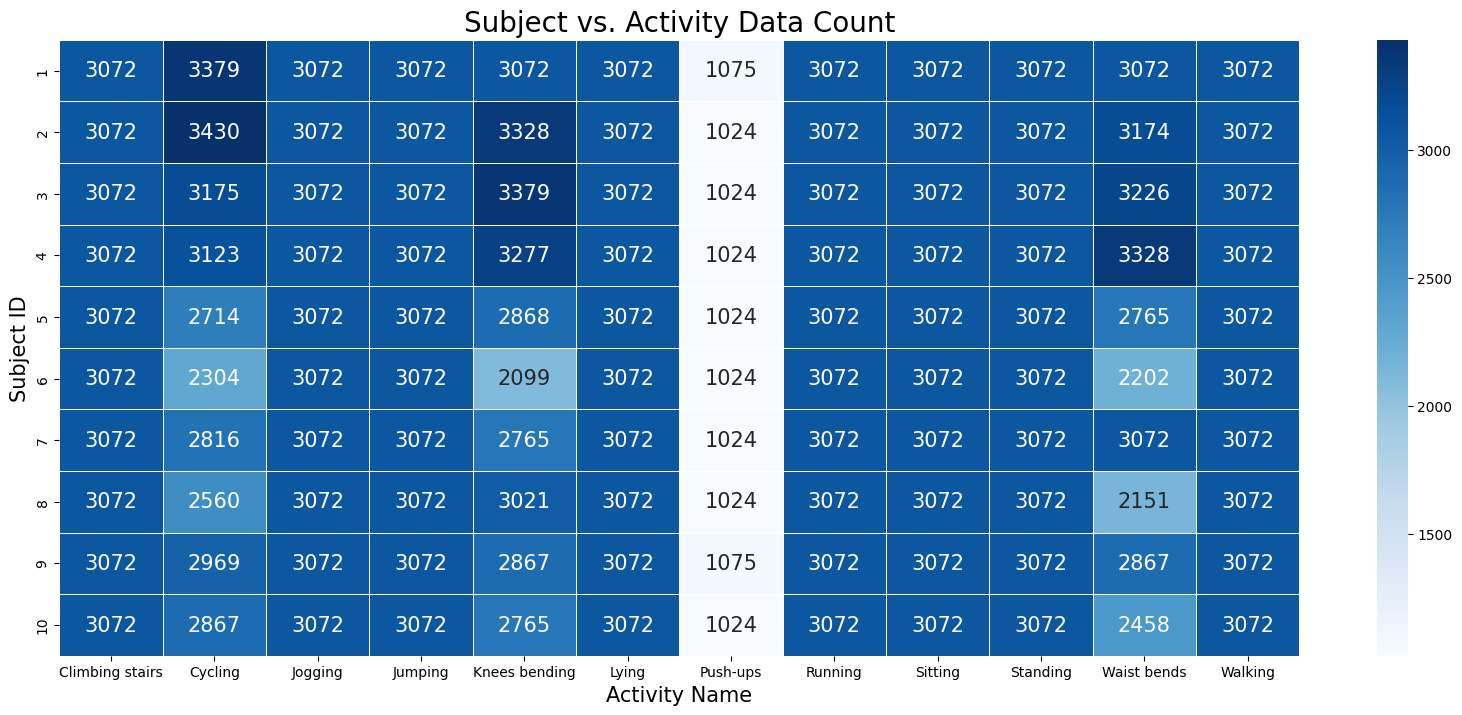

In [36]:
# Aggregate data count by subject_id and activity_name
subject_activity_matrix = df_raw.groupby(['subject_id', 'activity_name'])['acc_chest_x'].count().unstack(fill_value=0)

plt.figure(figsize=(20, 8)) # 12 activities (wide), 10 subjects (tall)
sns.heatmap(
    subject_activity_matrix, 
    annot=True, 
    fmt='d',     # Format as integer
    cmap='Blues', 
    linewidths=.5,
    annot_kws={"size": 15}
)
plt.title('Subject vs. Activity Data Count', fontsize=20)
plt.xlabel('Activity Name', fontsize=15)
plt.ylabel('Subject ID', fontsize=15)
plt.show()

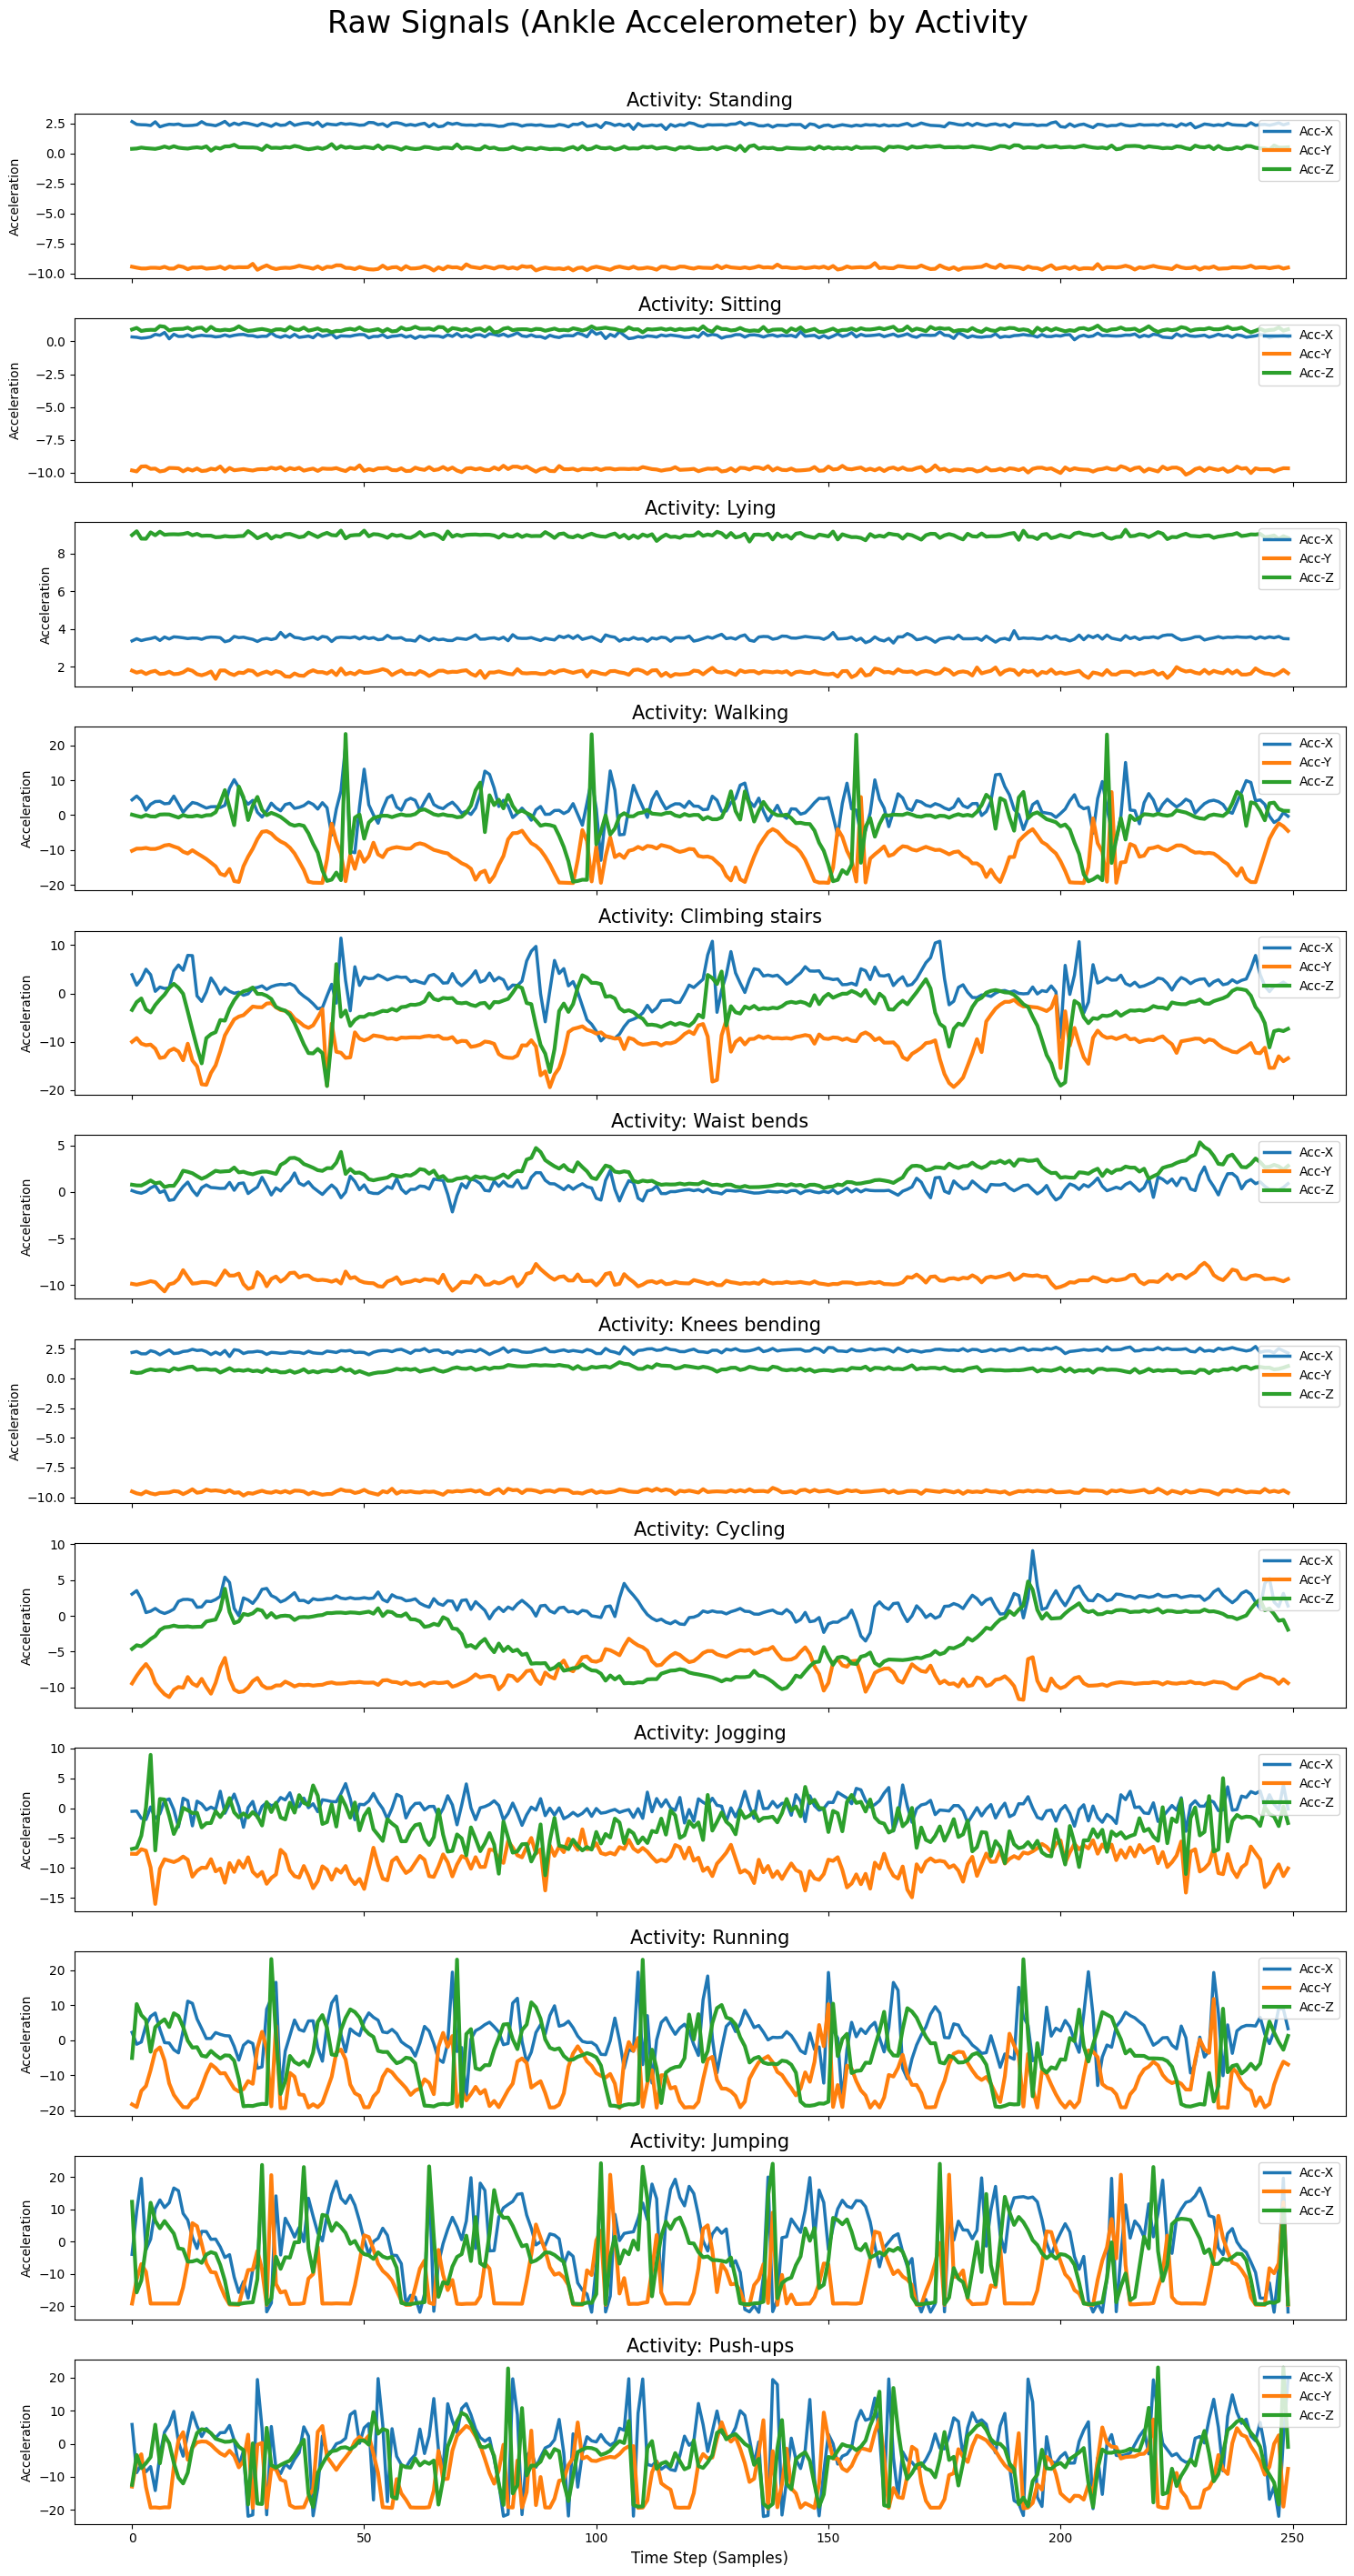

In [40]:
# Get the 12 activity names
activity_names_map = df_raw[['activity_id', 'activity_name']].drop_duplicates()
activity_names_map = activity_names_map.sort_values(by='activity_id')

# Get 250 continuous samples (5 seconds @ 50Hz) for each activity
samples_to_plot = {}
for act_id, act_name in activity_names_map.values:
    # Get the first 250 samples for this activity
    activity_sample = df_raw[df_raw['activity_id'] == act_id].iloc[:250]
    samples_to_plot[act_name] = activity_sample

# --- Create Plot ---
# 12 activities
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(15, 28), sharex=True)
fig.suptitle('Raw Signals (Ankle Accelerometer) by Activity', fontsize=24, y=1.01)

# X-axis (samples)
time_steps = np.arange(250)

for i, (activity_name, sample_data) in enumerate(samples_to_plot.items()):
    ax = axes[i]
    ax.plot(time_steps, sample_data['acc_ankle_x'], label='Acc-X', linewidth=2.5)
    ax.plot(time_steps, sample_data['acc_ankle_y'], label='Acc-Y', linewidth=3)
    ax.plot(time_steps, sample_data['acc_ankle_z'], label='Acc-Z', linewidth=3)
    ax.set_title(f'Activity: {activity_name}', fontsize=15)
    ax.set_ylabel('Acceleration')
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Time Step (Samples)', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

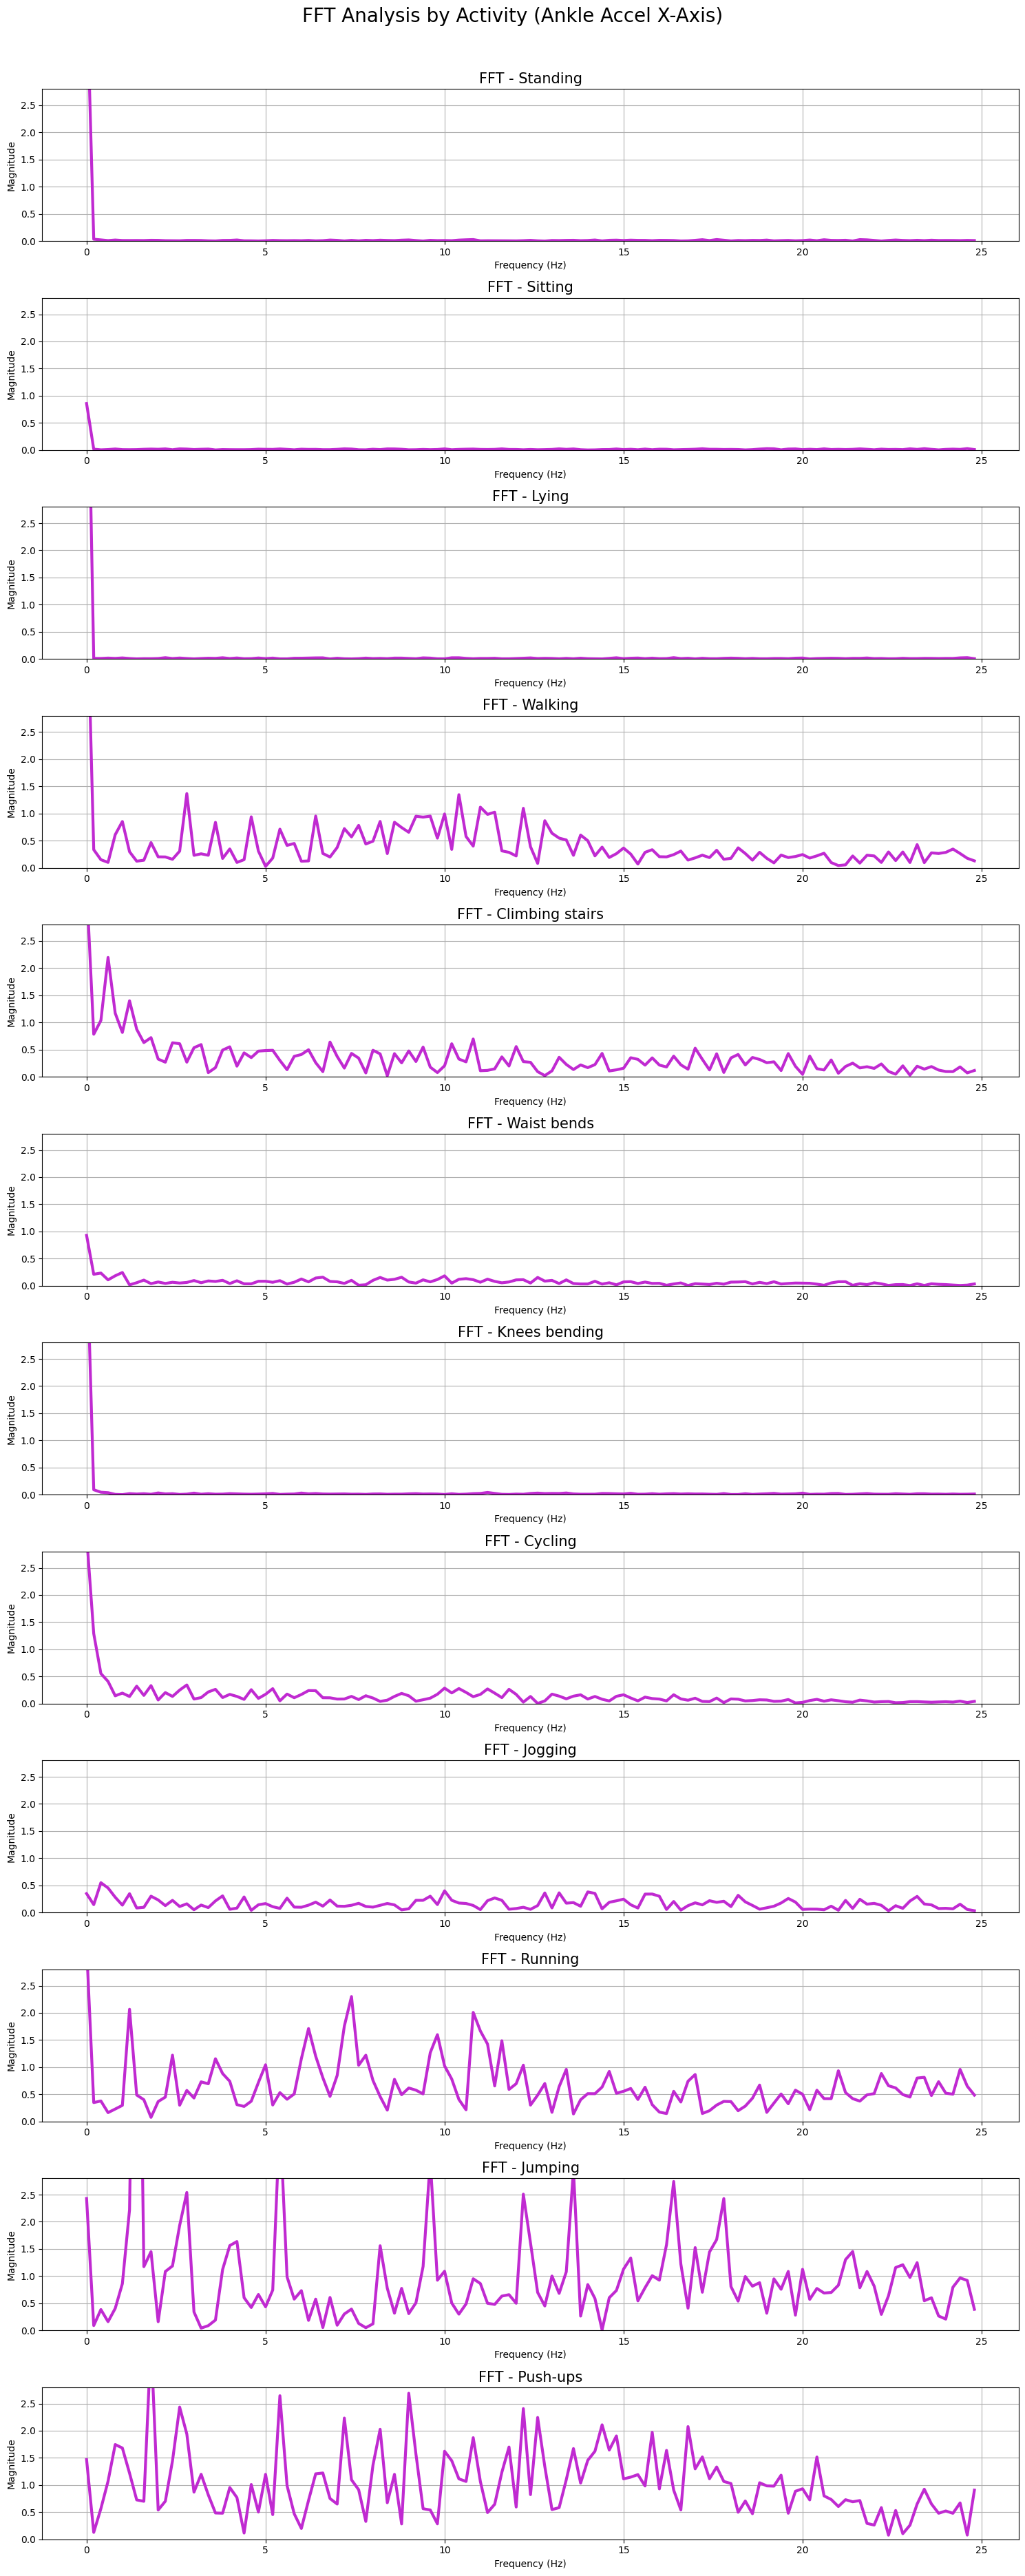

In [47]:
# Sampling Rate (MHEALTH = 50Hz)
SAMPLING_RATE = 50
# Window Size (We used 250 samples)
N = 250

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(15, 37))
fig.suptitle('FFT Analysis by Activity (Ankle Accel X-Axis)', fontsize=20, y=1.01)

# X-axis (Frequency)
# 50Hz, 250 samples -> 0-25Hz range (Nyquist)
xf = fftfreq(N, 1 / SAMPLING_RATE)[:N//2] # Use N//2

for i, (activity_name, sample_data) in enumerate(samples_to_plot.items()):
    # Use Ankle Accel X-axis signal
    signal = sample_data['acc_ankle_x'].values
    
    # Perform FFT
    yf = fft(signal)
    # Calculate Magnitude
    magnitude = 2.0/N * np.abs(yf[0:N//2])

    # Visualization
    ax = axes[i]
    ax.plot(xf, magnitude, '#c02ad1', linewidth=3)
    ax.set_title(f'FFT - {activity_name}', fontsize=15)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.grid(True)
    # Fix Y-axis scale for better comparison (adjust as needed)
    ax.set_ylim(0, 2.8) 

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [48]:
# --- Settings ---
# 2.56 seconds * 50 Hz = 128 steps
TIME_STEPS = 128
# 50% overlap = 64 steps
STEP = 64

# Define sensor columns we want to process (e.g., all 23 sensor cols)
SENSOR_COLS = [col for col in df_raw.columns if col not in ['activity_id', 'subject_id', 'activity_name']]
print(f"Using {len(SENSOR_COLS)} sensor columns for windowing.")

# --- Function to create windows ---
def create_windows_mhealth(data, time_steps, step, sensor_cols):
    segments = []
    labels = []
    subjects = []
    
    for (subject_id, activity_name), group in data.groupby(['subject_id', 'activity_name']):
        # Extract sensor values only
        sensor_data = group[sensor_cols].values
        
        for i in range(0, len(group) - time_steps, step):
            # Get window for all 23 sensors
            window_data = sensor_data[i:i + time_steps]
            
            # Add segment
            segments.append(window_data)
            # Add label
            labels.append(group['activity_id'].iloc[0]) # Get the activity ID
            # Add subject
            subjects.append(subject_id)
            
    # Reshape segments to (N_windows, 128_timesteps, 23_channels)
    reshaped_segments = np.array(segments)
    
    return reshaped_segments, np.array(labels), np.array(subjects)

print("Applying sliding windows to df_raw (MHEALTH)...")
X_windows, y_windows, subjects_windows = create_windows_mhealth(
    df_raw, TIME_STEPS, STEP, SENSOR_COLS
)

print(f"Windowing complete.")
print(f"Windows Shape (X): {X_windows.shape}") # (N_windows, 128, 23)
print(f"Labels Shape (y): {y_windows.shape}")   # (N_windows,)

Using 23 sensor columns for windowing.
Applying sliding windows to df_raw (MHEALTH)...
Windowing complete.
Windows Shape (X): (5133, 128, 23)
Labels Shape (y): (5133,)



DataFrame with Statistical Features (from windows):


,activity_id,subject_id,activity_name,std_acc_chest_x,std_acc_ankle_x,std_acc_arm_x
0,5,1,Climbing stairs,1.723632,3.973205,1.189228
1,5,1,Climbing stairs,1.682473,4.093239,1.430314
2,5,1,Climbing stairs,1.424118,2.560583,1.086585
3,5,1,Climbing stairs,1.560390,2.294466,1.118453
4,5,1,Climbing stairs,1.618083,2.429271,1.179781


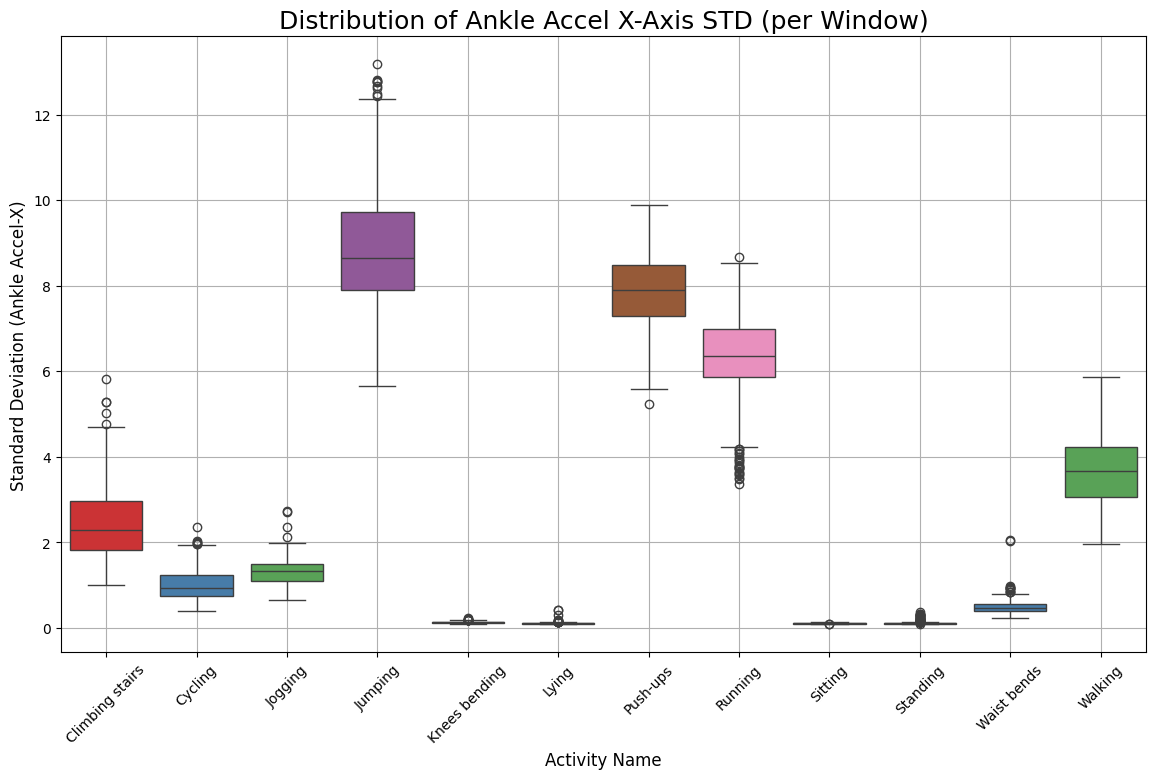

In [50]:
# 1. Create a DataFrame for plotting
# (Get activity names mapping)
ACTIVITY_MAP_simple = df_raw.set_index('activity_id')['activity_name'].to_dict()

df_windows_features = pd.DataFrame({
    'activity_id': y_windows,
    'subject_id': subjects_windows
})
df_windows_features['activity_name'] = df_windows_features['activity_id'].map(ACTIVITY_MAP_simple)


# 2. Calculate statistical features (STD) from X_windows
# X_windows shape: (N_windows, 128, 23)
# Col 0: acc_chest_x
# Col 5: acc_ankle_x
# Col 14: acc_arm_x

# Calculate std() across the 128 timesteps (axis=1)
df_windows_features['std_acc_chest_x'] = np.std(X_windows[:, :, 0], axis=1)
df_windows_features['std_acc_ankle_x'] = np.std(X_windows[:, :, 5], axis=1)
df_windows_features['std_acc_arm_x'] = np.std(X_windows[:, :, 14], axis=1)

print("\nDataFrame with Statistical Features (from windows):")
display(df_windows_features.head())

# 3. Plot Boxplot (e.g., for Ankle X-axis std)
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='activity_name', 
    y='std_acc_ankle_x', # Compare Ankle sensor
    data=df_windows_features,
    palette='Set1'
)
plt.title('Distribution of Ankle Accel X-Axis STD (per Window)', fontsize=18)
plt.xlabel('Activity Name', fontsize=12)
plt.ylabel('Standard Deviation (Ankle Accel-X)', fontsize=12)
plt.xticks(rotation=45) # 12 activities, so rotate labels
plt.grid(True)
plt.show()

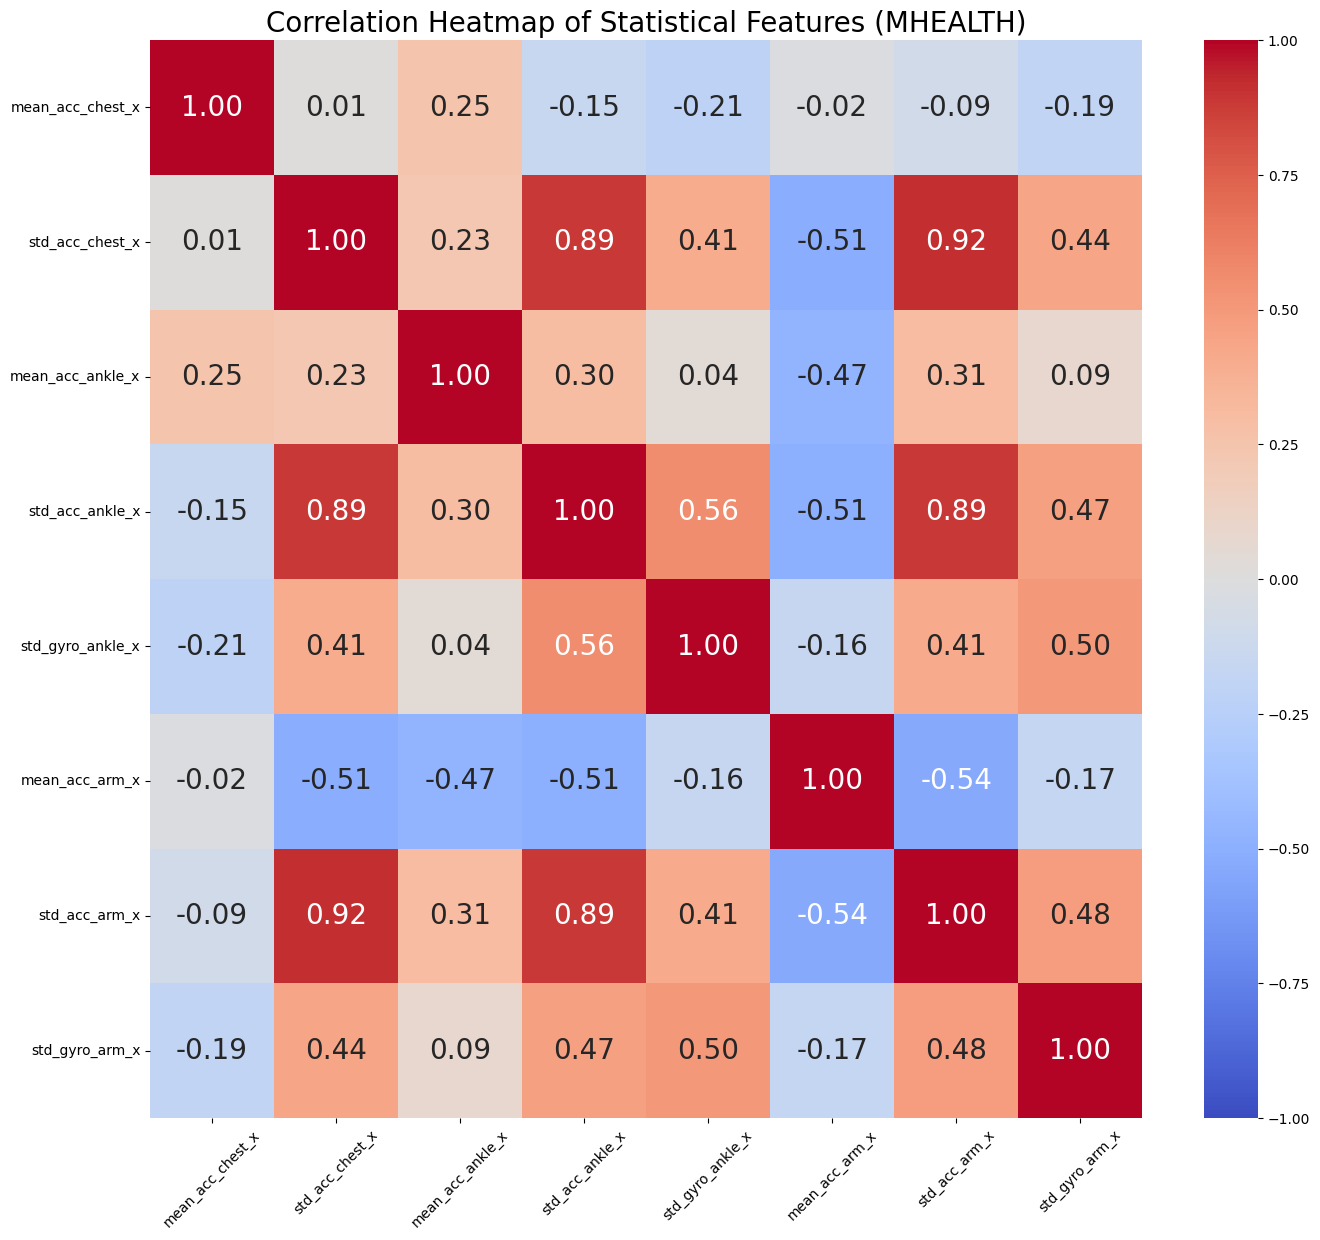

In [52]:
# Calculate more features (Mean) for a richer heatmap
df_windows_features['mean_acc_chest_x'] = np.mean(X_windows[:, :, 0], axis=1)
df_windows_features['mean_acc_ankle_x'] = np.mean(X_windows[:, :, 5], axis=1)
df_windows_features['mean_acc_arm_x'] = np.mean(X_windows[:, :, 14], axis=1)
# (Add Gyro features for comparison)
df_windows_features['std_gyro_ankle_x'] = np.std(X_windows[:, :, 8], axis=1)
df_windows_features['std_gyro_arm_x'] = np.std(X_windows[:, :, 17], axis=1)

# Select only feature columns for correlation
features_for_corr = df_windows_features[[
    'mean_acc_chest_x', 'std_acc_chest_x',
    'mean_acc_ankle_x', 'std_acc_ankle_x', 'std_gyro_ankle_x',
    'mean_acc_arm_x', 'std_acc_arm_x', 'std_gyro_arm_x'
]]

# Calculate correlation matrix
corr_matrix = features_for_corr.corr()

# Plot Heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    annot_kws={"size": 20},
    fmt='.2f', # Show 2 decimal places
    cmap='coolwarm', 
    vmin=-1, vmax=1 
)
plt.title('Correlation Heatmap of Statistical Features (MHEALTH)', fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()